# Introduction to PyTorch for Deep Learning

In this notebook we will use pytorch to build a simple neural network and classify the Iris dataset.

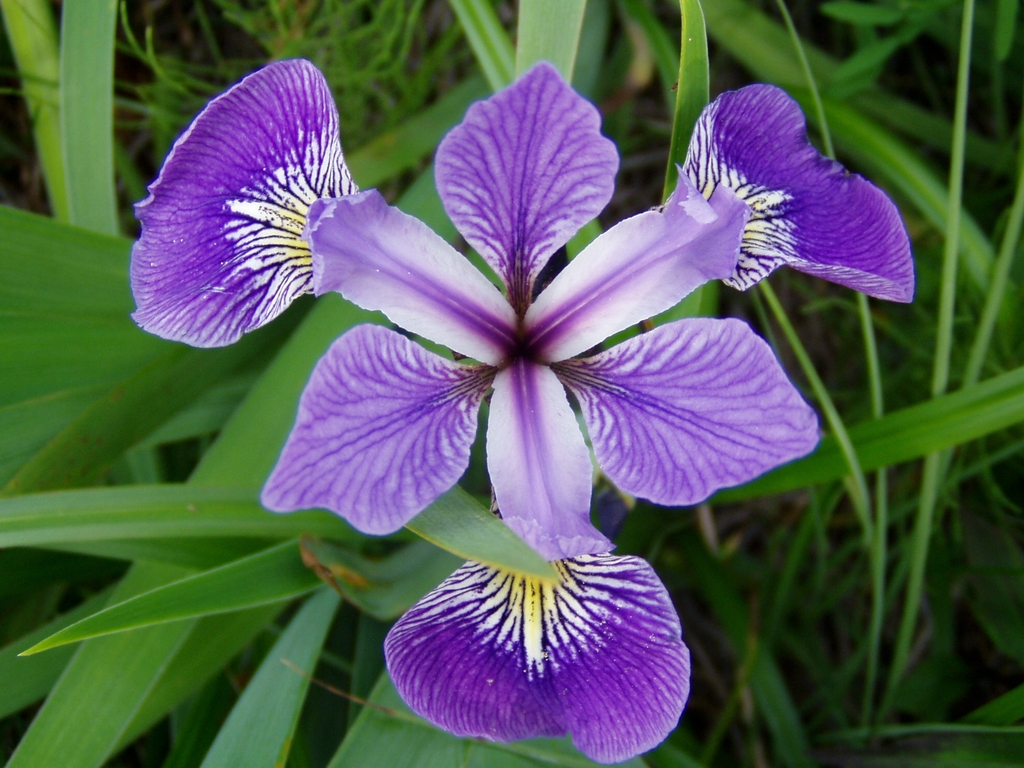

References:

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from copy import deepcopy
from tqdm import tqdm
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [2]:
# load iris data from sklearn
iris = load_iris()
data = iris.data[:,:].astype(np.float32)
targ = iris.target.astype(np.int32)

In [3]:
# split data into train and test
x_train, x_test, y_train, y_test = train_test_split(data, targ, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
print(
    x_train.shape, y_train.shape, 
    x_val.shape, y_val.shape,
    x_test.shape, y_test.shape,
    )

(108, 4) (108,) (12, 4) (12,) (30, 4) (30,)


In [4]:
# a Dataset class for pytorch. Dataset is a class for data loading and preprocessing
# it is used in conjunction with DataLoader class for batch processing
# Dataset class is a subclass of torch.utils.data.Dataset
# it has 3 methods: __init__, __getitem__, __len__
# __init__ is the constructor
# __getitem__ is used to get a sample from the dataset given an index
# __len__ is used to get the length of the dataset

# There are 3 different ways to create a Dataset class: torch.tensor, torch.from_numpy, and torch.utils.data.TensorDataset

class DataTrain(Dataset):
    def __init__(self, X, y):
        assert len(X) == len(y)
        self.x = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return len(self.y)

# Could also use torch.utils.data.TensorDataset
# train_dataset = TensorDataset(x_train, y_train)
# test_dataset = TensorDataset(x_test, y_test)

In [5]:
# set batch size to 10, meaning that every 10 samples will be grouped together as a batch for processing
batch_size = 10

# create train and test data classes
train_data = DataTrain(x_train, y_train)
val_data = DataTrain(x_val, y_val)
test_data = DataTrain(x_test, y_test)

# instantiate data loaders
# DataLoader is a class for batch processing
# it is used in conjunction with Dataset class
# DataLoader class is a subclass of torch.utils.data.DataLoader
# it has 3 methods: __init__, __iter__, __len__
# __init__ is the constructor
# __iter__ is used to iterate over the dataset
# __len__ is used to get the length of the dataset
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# print out the shapes of the data
print(len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset))

108 12 30


In [6]:
# build neural network class
class NeuralNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        # define layers
        self.fc1 = nn.Linear(input_dim, 10)
        self.output = nn.Linear(10, output_dim)

    def forward(self, x):
        # define forward pass of data through the network including activation functions
        x = F.relu(self.fc1(x))
        x = self.output(x)
        return x

In [7]:
def train_classification(model, data_loader, optimizer, criterion, device):
    model.to(device).train()
    batch_loss = []
    correct = 0
    total_samples = 0

    for x, y in data_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
        correct += (y_hat.argmax(1) == y).sum().item()
        total_samples += y.size(0)

    accuracy = 100.0 * correct / total_samples
    loss_total = sum(batch_loss) / len(batch_loss)

    return loss_total, accuracy

def validate_classification(model, data_loader, criterion, device):
    model.to(device).eval()
    batch_loss = []
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            batch_loss.append(loss.item())
            correct += (y_hat.argmax(1) == y).sum().item()
            total_samples += y.size(0)

    accuracy = 100.0 * correct / total_samples
    loss_total = sum(batch_loss) / len(batch_loss)

    return loss_total, accuracy

def evaluate_classification(model, data_loader, device):
    model.to(device).eval()
    correct = 0
    total_samples = 0
    predictions = []
    actuals = []

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            predictions.append(y_hat.argmax(1))
            actuals.append(y)
            correct += (y_hat.argmax(1) == y).sum().item()
            total_samples += y.size(0)

    predictions = torch.cat(predictions, dim=0).cpu().numpy()
    actuals = torch.cat(actuals, dim=0).cpu().numpy()
    accuracy = 100.0 * correct / total_samples

    return predictions, actuals, accuracy

def predict_classification(model, data_loader, device):
    model.to(device).eval()
    predictions = []

    with torch.no_grad():
        for x_batch in data_loader:
            x_batch = x_batch.to(device)
            y_hat = model(x_batch)
            predictions.append(y_hat.argmax(dim=1))

    predictions = torch.cat(predictions, dim=0).cpu().numpy()
    return predictions

class EarlyStopper:
    def __init__(
        self, patience: int = 1, min_delta: float = 0.0, verbose: bool = False
    ):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float("inf")
        self.best_model_weights = None
        self.verbose = verbose

    def early_stop(self, loss:float, model:nn.Module):
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.counter = 0
            self.save_best_weights(model)
        else:
            self.counter += 1
            if self.verbose:
                print(f"Early Stopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                return True
        return False

    def save_best_weights(self, model):
        self.best_model_weights = deepcopy(model.state_dict())

    def restore_best_weights(self, model):
        model.load_state_dict(self.best_model_weights)

In [8]:
# training lists and parameters
n_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# instantiate model, loss function and optimizer
model = NeuralNet(x_train.shape[1], 3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=0.01)
early_stopper = EarlyStopper(patience=10, min_delta=0.0001)

In [9]:
# lists to store loss and accuracy
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []

for epoch in tqdm(range(n_epochs), desc='Training Progress'):
    epoch_train_loss, epoch_train_acc = train_classification(model, train_loader, optimizer, criterion, device)
    train_loss.append(epoch_train_loss)
    train_accuracy.append(epoch_train_acc)

    epoch_val_loss, epoch_val_acc = validate_classification(model, val_loader, criterion, device)
    val_loss.append(epoch_val_loss)
    val_accuracy.append(epoch_val_acc)

    print(f'[{epoch+1}/{n_epochs}] Train loss: {epoch_train_loss:.4f} acc: {epoch_train_acc:.2f}% - Val loss: {epoch_val_loss:.4f} acc: {epoch_val_acc:.2f}%')
    if early_stopper.early_stop(epoch_val_loss, model):
        early_stopper.restore_best_weights(model)
        print("Early Stopping triggered: Restoring best weights")
        break

 12%|█▏        | 12/100 [00:00<00:01, 49.16it/s]

[1/100] Train loss: 0.7525 acc: 58.33% - Val loss: 0.4254 acc: 66.67%
[2/100] Train loss: 0.4421 acc: 69.44% - Val loss: 1.0774 acc: 58.33%
[3/100] Train loss: 0.2893 acc: 82.41% - Val loss: 0.2932 acc: 91.67%
[4/100] Train loss: 0.2818 acc: 87.04% - Val loss: 0.5330 acc: 83.33%
[5/100] Train loss: 0.2459 acc: 85.19% - Val loss: 2.3269 acc: 58.33%
[6/100] Train loss: 0.4307 acc: 79.63% - Val loss: 0.9362 acc: 75.00%
[7/100] Train loss: 0.1859 acc: 96.30% - Val loss: 0.5953 acc: 83.33%
[8/100] Train loss: 0.1300 acc: 99.07% - Val loss: 0.6554 acc: 83.33%
[9/100] Train loss: 0.1100 acc: 97.22% - Val loss: 0.5670 acc: 83.33%
[10/100] Train loss: 0.0877 acc: 98.15% - Val loss: 0.4812 acc: 83.33%
[11/100] Train loss: 0.0806 acc: 99.07% - Val loss: 0.7320 acc: 83.33%
[12/100] Train loss: 0.1269 acc: 95.37% - Val loss: 1.6855 acc: 75.00%
[13/100] Train loss: 0.2881 acc: 84.26% - Val loss: 0.9251 acc: 83.33%
Patience Depleated: Early Stopping triggered.


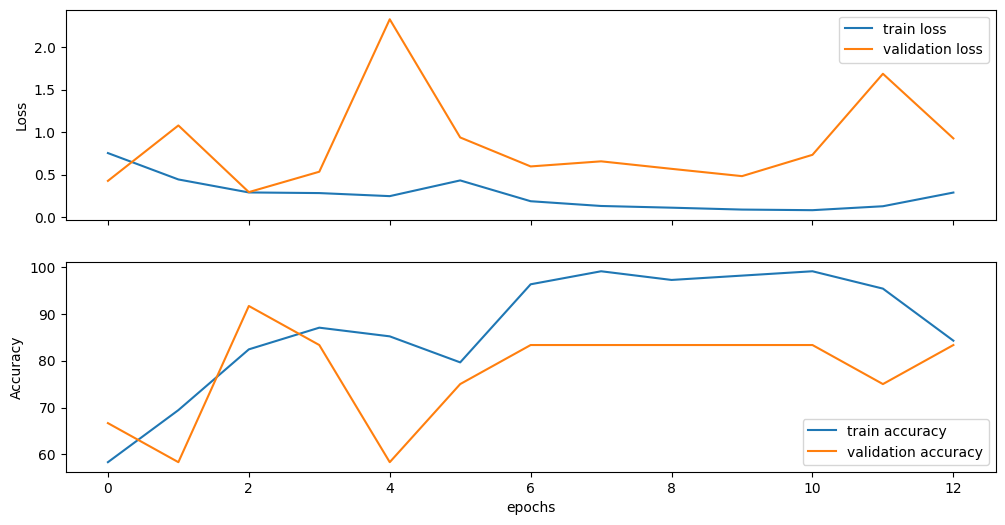

In [10]:
# plot loss and accuracy
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(train_loss, label="train loss")
ax1.plot(val_loss, label="validation loss")
ax1.set_ylabel("Loss")
ax2.plot(train_accuracy, label="train accuracy")
ax2.plot(val_accuracy, label="validation accuracy")
ax2.set_ylabel("Accuracy")
ax2.set_xlabel("epochs")
ax1.legend()
ax2.legend()

In [11]:
# predict on test data
predictions, actuals, accuracy = evaluate_classification(model, test_loader, device)
print(f"Accuracy on test data: {accuracy:.2f}%")
print(f"The predictions are: {predictions}")

Accuracy on test data: 96.67%
The predictions are: [1 0 2 1 1 0 1 2 2 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0]


In [12]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[ 1.6136e-03,  3.2681e-05,  1.4195e-03, -1.5999e-04],
        [ 4.9268e-01,  1.0354e+00, -8.1602e-01, -1.4159e+00],
        [-5.4407e-02,  8.4964e-04, -3.1651e-02,  6.9097e-04],
        [-1.2255e-01, -5.7089e-01,  1.2543e+00,  1.2630e+00],
        [-6.3661e-02, -6.0235e-02,  4.5210e-02, -1.8803e-03],
        [-6.7482e-02, -1.9735e-02, -3.6553e-04,  1.4388e-04],
        [ 4.6180e-01,  5.5707e-01, -7.8866e-01, -5.7271e-01],
        [ 2.9073e-01,  3.7256e-01, -6.0931e-01, -4.8706e-01],
        [-2.2938e-02, -6.3929e-03, -2.5711e-02,  1.4069e-02],
        [-7.1305e-03, -7.8754e-05, -3.6671e-02, -1.7289e-04]], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([ 7.4181e-04,  1.1019e+00,  6.7119e-04, -3.1146e-01,  1.9670e-03,
        -3.6914e-04,  1.7623e-01,  7.6963e-02,  5.9403e-03,  3.9578e-04],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-1.1246e-04,  9.3451e-01, -1.0976e-04, -1.1393e+00,  2.0939e-04,
    